## Creating Time Window
Info:

- window size: 20 sec
- sliding step : 1 sec = 50 Hz
- overlapping windows
- size: 1000samples = 20 seconds * 50 Hz  
- every participant has 63000 samples
- each window does

In [28]:
import numpy as np
import pandas as pd

# Load the preprocessed data
data = pd.read_csv('Data/preprocessed_data.csv')
data.head()


,time_stamp,participant,activity,accel_magnitude
0,1.390000e+12,1,walking,15.043465
1,1.390000e+12,1,walking,14.097451
2,1.390000e+12,1,walking,14.744242
3,1.390000e+12,1,walking,13.321392
4,1.390000e+12,1,walking,12.133143


### Overlapping windows with 1-second steps and 20-second window length


In [29]:
window_size = 1000   # 20 seconds * 50 Hz
step_size = 50       # 1 second * 50 Hz

windows = []
activities = []
participants = []

# Group by participant and apply sliding window to each group
for participant_id, group in data.groupby('participant'):
    group = group.reset_index(drop=True)
    for start in range(0, len(group) - window_size + 1, step_size):
        end = start + window_size
        window = group.iloc[start:end]
        windows.append(window)
        majority_activity = window['activity'].mode()[0]# Get the majority activity
        #The [0] index ensures that, in case of a tie, the first mode is selected
        activities.append(majority_activity)
        participants.append(participant_id)

print(f'Total windows created: {len(windows)}')

Total windows created: 12410


In [31]:
# Convert the list of windows and activities into a DataFrame
windowed_data = pd.DataFrame({'window': windows, 'majority_activity': activities, 'participant': participants})
#Each value in the window column is a DataFrame containing all the samples for that window.
#This allows you to later extract features or perform further analysis on each window.
# Display the first few entries of the windowed data
windowed_data.sample(5)

,window,majority_activity,participant
9122,time_stamp participant activity acc...,jogging,8
7094,time_stamp participant activity ac...,biking,6
9601,time_stamp participant activity ac...,upstairs,8
9621,time_stamp participant activity ac...,upstairs,8
9172,time_stamp participant activity acc...,jogging,8


### Feature Extraction
1.	Μέσος όρος των τιμών του παραθύρου (mean())
2.	Τυπική απόκλιση των τιμών του παραθύρου (std())
3.	Ασυμμετρία κατανομής - skewness (skewness() ή skew() στο SciPy)
4.	Μέγιστη τιμή (max())
5.	Ελάχιστη τιμή (min())
6.	Διαφορά μεταξύ μέγιστης και ελάχιστης τιμής (max() - min())
7.	Εκτίμηση ισχύος φάσματος με τη μέθοδο του Welch --> maximum, bandwidth, centroids

In [32]:
from scipy.stats import skew
from scipy.signal import welch

def extract_features(window, fs=50):
    x = window['accel_magnitude'].values.astype(float)
    features = {}
    features['mean'] = np.mean(x)
    features['std'] = np.std(x)
    features['skewness'] = skew(x)
    features['max'] = np.max(x)
    features['min'] = np.min(x)
    features['range'] = np.max(x) - np.min(x)
    # Welch's method for power spectral density
    f, Pxx = welch(x, fs=fs)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    
    # Μπορείς να κρατήσεις όλο το φάσμα ή π.χ. το άθροισμα ή το μέγιστο αργότερα εξετάζουμε και άλλα στατιστικά
    #features['psd_sum'] = np.sum(Pxx)
    features['psd_max'] = np.max(Pxx)
    # Αν θέλεις όλο το φάσμα:-- δεν χρειάζεται
    # for i, val in enumerate(Pxx):
    #     features[f'psd_{i}'] = val
    return features

# Εξαγωγή χαρακτηριστικών για όλα τα παράθυρα
feature_list = []
for window in windows:
    feats = extract_features(window)
    feature_list.append(feats)

features_df = pd.DataFrame(feature_list)
features_df['majority_activity'] = activities
features_df.sample(5)

,mean,std,skewness,max,min,range,psd_max,majority_activity
1408,10.944005,3.398157,0.679796,21.691358,4.037264,17.654094,15.834558,walking
8186,9.845016,1.802482,0.020754,16.247098,2.552824,13.694275,2.254885,biking
12210,10.850501,4.299196,0.237779,26.055595,0.776003,25.279592,16.585048,upstairs
9715,10.714246,3.781571,0.383089,23.514553,1.299081,22.215473,13.872527,upstairs
2585,11.104092,3.849695,-0.019715,21.245746,2.858601,18.387145,12.488860,walking


In [33]:
features_df.sample(5)

,mean,std,skewness,max,min,range,psd_max,majority_activity
8173,9.795258,1.222727,-0.052830,13.370265,6.679618,6.690647,2.391578,biking
6113,10.654273,4.747540,0.315539,23.790143,1.739665,22.050478,19.818239,downstairs
10419,13.633257,5.976843,0.278358,27.558746,2.322122,25.236623,26.924836,jogging
7207,10.402842,3.808039,0.586946,28.412755,2.832466,25.580289,8.842524,upstairs
4577,9.742933,1.607354,0.725955,20.705682,4.882174,15.823508,4.244178,biking


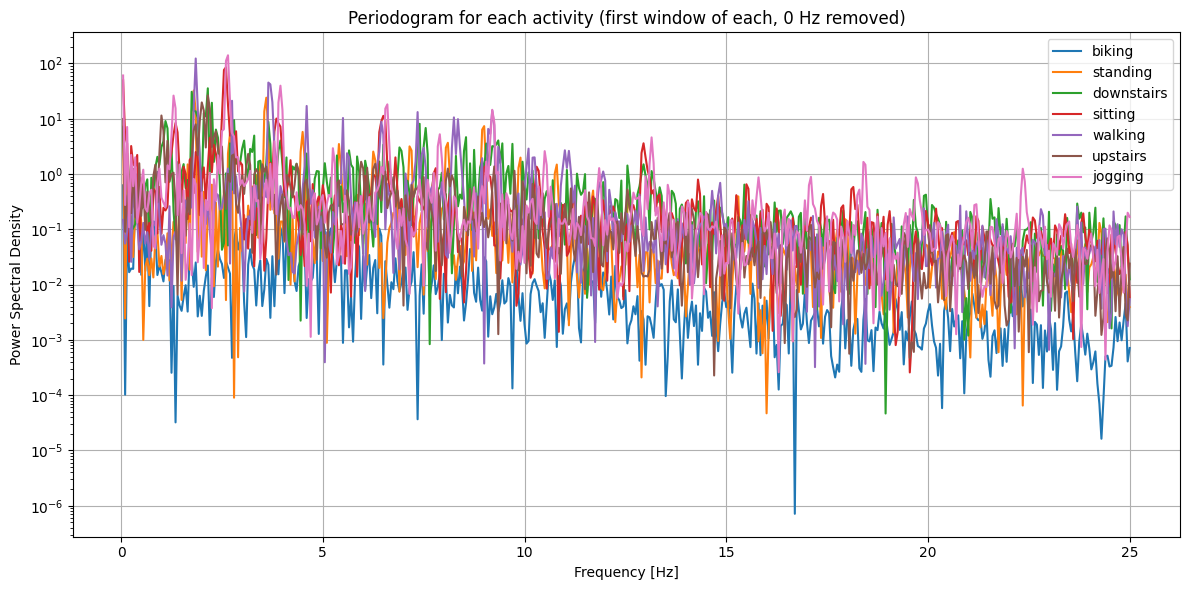

In [34]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = periodogram(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Periodogram for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

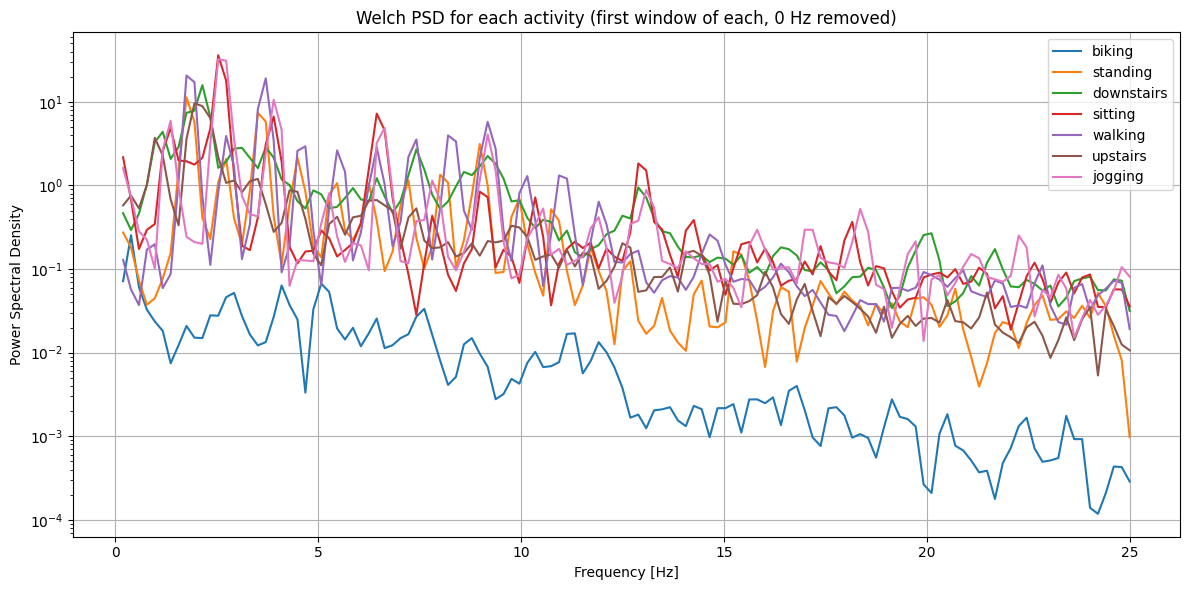

In [35]:
from scipy.signal import welch
import matplotlib.pyplot as plt


unique_activities = list(set(activities))
fs = 50  # Sampling frequency

plt.figure(figsize=(12, 6))

for activity in unique_activities:
    # Find indices of windows with the current activity
    activity_indices = [i for i, act in enumerate(activities) if act == activity]
    if activity_indices:
        idx = activity_indices[0]
        window = windows[idx]
        x = window['accel_magnitude'].values.astype(float)
        f, Pxx = welch(x, fs=fs)
        # Remove the 0 Hz component
        f = f[1:]
        Pxx = Pxx[1:]
        plt.semilogy(f, Pxx, label=str(activity))
    else:
        print(f"No windows found for activity: {activity}")

plt.title('Welch PSD for each activity (first window of each, 0 Hz removed)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Need to decide how this feature to be used

In [36]:
# Save the windowed data to a new CSV file
output_windowed_file_path = 'Data/windowed_data.csv'
windowed_data.to_csv(output_windowed_file_path, index=False)
print(f'Windowed data saved to {output_windowed_file_path}')

Windowed data saved to Data/windowed_data.csv


#### Use of Spectral Bandwidth (Spread) and Spectral Centroid from PSD
Bandwidth / Spectral Spread
- Standard deviation around the spectral centroid.

- Reflects how concentrated or dispersed the frequency content is.

Spectral Centroid μ is:
$$
\mu = \frac{\sum_{i} f_i \cdot P(f_i)}{\sum_{i} P(f_i)}
$$

The spectral bandwidth  B is the standard deviation of the frequencies around the spectral centroid:

$$
B = \sqrt{ \frac{\sum_{i} (f_i - \mu)^2 \cdot P(f_i)}{\sum_{i} P(f_i)} }
$$

These features help characterize the distribution of frequency content for different activities
(Other options can be: Peak Frequency, Mean Freq, Spectral Entropy, Spectral Energy, Number of Peaks, Dominant Frequency Ratio, or even all of them and then do feature importance test).

In [37]:
# Compute spectral centroid and bandwidth for each window
centroids = []
bandwidths = []

def spectral_centroid_and_bandwidth(signal, fs):
    """
    Computes the spectral centroid and bandwidth (spread) of a signal using Welch's method.

    Parameters:
    - signal: 1D numpy array of the signal (accelerometer magnitude).
    - fs: Sampling frequency in Hz.

    Returns:
    - centroid: Spectral centroid in Hz.
    - bandwidth: Spectral bandwidth (standard deviation around the centroid) in Hz.
    """
    # Compute Welch's Power Spectral Density
    freqs, psd = welch(signal, fs=fs, nperseg=256)

    # Remove 0 Hz (DC component) to avoid bias
    freqs = freqs[1:]
    psd = psd[1:]

    # Normalize the PSD to make it a probability distribution
    psd_norm = psd / np.sum(psd)

    # Spectral centroid (weighted mean of frequencies)
    centroid = np.sum(freqs * psd_norm)

    # Spectral bandwidth (standard deviation around the centroid)
    bandwidth = np.sqrt(np.sum(((freqs - centroid) ** 2) * psd_norm))

    return centroid, bandwidth


for window in windows:
    x = window['accel_magnitude'].values.astype(float)
    centroid, bandwidth = spectral_centroid_and_bandwidth(x, fs=50)
    centroids.append(centroid)
    bandwidths.append(bandwidth)

# Add the new features to features_df
features_df['spectral_centroid'] = centroids # mean frequency of the signal
features_df['spectral_bandwidth'] = bandwidths #a measure of how spread out the frequency content of a signal is around its spectral centroid.

# Show a sample with the new features and activity labels
features_df[['spectral_centroid', 'spectral_bandwidth', 'majority_activity']].sample(5)


,spectral_centroid,spectral_bandwidth,majority_activity
9304,11.860457,7.070250,sitting
6251,5.625621,4.056342,walking
5604,10.261986,5.874684,sitting
3263,3.904257,4.354305,biking
1458,4.452216,2.976686,standing


In [38]:
print(f'All extracted features from the magnitude of the accelerometer are: \n{features_df.columns.tolist()}')

All extracted features from the magnitude of the accelerometer are: 
['mean', 'std', 'skewness', 'max', 'min', 'range', 'psd_max', 'majority_activity', 'spectral_centroid', 'spectral_bandwidth']


In [39]:
windowed_data.sample(5)
features_df.shape

(12410, 10)

In [40]:
# Save the features DataFrame to a new CSV file
output_features_file_path = 'Data/features_data.csv'
features_df.to_csv(output_features_file_path, index=False)

In [ ]:
# Ensure 'participant' column exists in features_df before saving

if 'participant' not in features_df.columns:
    # Assign participant to each window based on the original data index
    # Each window is a DataFrame, so get the participant from the first row of each window
    participants = [int(window['participant'].iloc[0]) for window in windows]
    features_df['participant'] = participants

# Save the extracted features to a new CSV file
output_features_file_path = 'Data/features_df.csv'
features_df.to_csv(output_features_file_path, index=False)
print(f'Features DataFrame saved to {output_features_file_path}')